# 1. Import Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2

# 2. Load Data

The data is manually gathered of my own face using python libraries open cv to capture images around 90 and then manually annotations on each image to generate labels in the format of .json

## 2.1 Creating Necessary Folders

In [3]:
import os

# Define the base path
base_path = "/content/drive/MyDrive/data"

# Define the required folders
folders = [
    "train/images", "train/labels",
    "test/images", "test/labels",
    "val/images", "val/labels",
    "data_augmentation/train/images", "data_augmentation/train/labels",
    "data_augmentation/test/images", "data_augmentation/test/labels",
    "data_augmentation/val/images", "data_augmentation/val/labels"
]

# Create the folders
for folder in folders:
    os.makedirs(os.path.join(base_path, folder), exist_ok=True)

print("Folders created successfully!")


Folders created successfully!


```
data/
├── train/
│   ├── images/
│   ├── labels/
├── test/
│   ├── images/
│   ├── labels/
├── val/
│   ├── images/
│   ├── labels/
├── data_augmentation/
│   ├── train/
│   │   ├── images/
│   │   ├── labels/
│   ├── test/
│   │   ├── images/
│   │   ├── labels/
│   ├── val/
│   │   ├── images/
│   │   ├── labels/

```



# 3. Loading Images into Tensorflow Pipeline

In [4]:
images = tf.data.Dataset.list_files('/content/drive/MyDrive/data/images/*.jpg')

In [5]:
img = images.as_numpy_iterator().next()

In [6]:
img

b'/content/drive/MyDrive/data/images/f08a8e66-e0b0-11ef-b44d-38d57a32e57a.jpg'

In [ ]:
# tf.io.read_file(img)

In [7]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [8]:
images = images.map(load_image)

In [144]:
images.as_numpy_iterator().next() ## showing the image in an array

#

# 4. Visualize Using Matplotlib

4 images in a single batch

In [10]:
batch = images.batch(4).as_numpy_iterator().next()

In [11]:
 batch.shape

(4, 480, 640, 3)

4 batches, 480 and 640 size of image, 3 color channels RGB

In [143]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(batch):
    ax[idx].imshow(image)
plt.show()

# 5. Partioning Data

In [13]:
train_dir = '/content/drive/MyDrive/data/train/images'
test_dir = '/content/drive/MyDrive/data/test/images'
val_dir = '/content/drive/MyDrive/data/val/images'

70% data -> training
15% data -> test
15% data -> val

In [14]:
image_list = list(images)

 Converting it into a list for more easy and efficient task

In [15]:
len(image_list)

91

## 5.1 Taking Size Of Train,Test,Val

In [16]:
train_size = int(len(image_list)*0.7)
test_size = int(len(image_list)*0.15)
val_size = int(len(image_list)*0.15)+2

In [17]:
print(f"train size:{train_size}\ntest size:{test_size}\nval size:{val_size}\nTotal Size:{train_size+test_size+val_size}")

train size:63
test size:13
val size:15
Total Size:91


## 5.2 Random Shuffle

In [18]:
import random

## 5.3 Splitting Data

In [19]:
img_dir = '/content/drive/MyDrive/data/images'

In [20]:
image_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]

In [21]:
train_images = image_files[:train_size]
test_images = image_files[train_size:train_size + test_size]
val_images = image_files[train_size + test_size:]

In [22]:
len(val_images)

15

In [23]:
import shutil

In [24]:
def move_images(image_list, target_dir):
    for img in image_list:
        src_path = os.path.join(img_dir, img)
        dest_path = os.path.join(target_dir, img)
        shutil.copy(src_path, dest_path)

In [25]:
move_images(train_images, train_dir)

In [26]:
move_images(test_images, test_dir)

In [27]:
move_images(val_images, val_dir)

## 5.4 Splitting Matching Labels

In [28]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('/content/drive/MyDrive/data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('/content/drive/MyDrive/data','labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('/content/drive/MyDrive/data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

# 6. Applying Data Augmentation

## 6.1 Testing On Single Picture

In [29]:
import albumentations as alb
import json

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [30]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

In [31]:
img = cv2.imread(os.path.join('/content/drive/MyDrive/data','train', 'images','924bd839-e0b0-11ef-9d99-38d57a32e57a.jpg'))

In [32]:
with open(os.path.join('/content/drive/MyDrive/data', 'train', 'labels', '924bd839-e0b0-11ef-9d99-38d57a32e57a.json'), 'r') as f:
    label = json.load(f)

In [33]:
label

{'version': '5.6.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[178.6111111111111, 117.77777777777777],
    [421.9444444444444, 395.55555555555554]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '..\\images\\924bd839-e0b0-11ef-9d99-38d57a32e57a.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVY

In [34]:
len(label['shapes'])

1

In [35]:
label['shapes'][0]['points']

[[178.6111111111111, 117.77777777777777],
 [421.9444444444444, 395.55555555555554]]

In [36]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [37]:
coords = list(np.divide(coords, [640,480,640,480]))

In [38]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [142]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [40]:
len(augmented['bboxes'])

1

## 6.2 Applying On All Images


In [41]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('/content/drive/MyDrive/data', partition, 'images')):
        img = cv2.imread(os.path.join('/content/drive/MyDrive/data', partition, 'images', image))
        # print(img)
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('/content/drive/MyDrive/data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            if len(label['shapes']) > 0:
              coords[0] = label['shapes'][0]['points'][0][0]
              coords[1] = label['shapes'][0]['points'][0][1]
              coords[2] = label['shapes'][0]['points'][1][0]
              coords[3] = label['shapes'][0]['points'][1][1]
              coords = list(np.divide(coords, [640,480,640,480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('/content/drive/MyDrive/data/data_augmentation', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0


                with open(os.path.join('/content/drive/MyDrive/data/data_augmentation', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

/usr/local/lib/python3.11/dist-packages/albumentations/core/bbox_utils.py:478: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)


# 6.3 Loading Augmented Images to Tf


In [42]:
train_images = tf.data.Dataset.list_files('/content/drive/MyDrive/data/data_augmentation/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [43]:
test_images = tf.data.Dataset.list_files('/content/drive/MyDrive/data/data_augmentation/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [44]:
val_images = tf.data.Dataset.list_files('/content/drive/MyDrive/data/data_augmentation/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [45]:
batch = val_images.batch(4).as_numpy_iterator().next()

In [141]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(batch):
    ax[idx].imshow(image)
plt.show()

## 6.4 Setting Up Labels For Each Folder

In [47]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [48]:
train_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/data/data_augmentation/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [49]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.1646, 0.2262, 0.705 , 0.8433], dtype=float16))

In [50]:
test_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/data/data_augmentation/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [51]:
val_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/data/data_augmentation/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

# 7. Merging Both Input And Label

In [52]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 780, 780, 900, 900)

In [53]:
len(train_labels)

3780

## 7.1 Splitting Into DataSets

In [54]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [55]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [56]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [57]:
test.as_numpy_iterator().next()[1][0][0]

array([0], dtype=uint8)

## 7.2 Visualizing Image With Borders


In [58]:
data_samples = train.as_numpy_iterator()

In [59]:
res = data_samples.next()

In [60]:
type(res)

tuple

In [61]:
res[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.3096 , 0.156  , 0.737  , 0.7437 ],
        [0.3079 , 0.2076 , 0.7524 , 0.7905 ],
        [0.4653 , 0.2983 , 0.8555 , 0.8057 ],
        [0.3013 , 0.1995 , 0.62   , 0.603  ],
        [0.8813 , 0.05777, 1.     , 0.7603 ],
        [0.00679, 0.2294 , 0.35   , 0.644  ],
        [0.07764, 0.2605 , 0.4973 , 0.774  ],
        [0.4504 , 0.2954 , 0.8184 , 0.772  ]], dtype=float16))

In [62]:
res[1][1][1]

array([0.3079, 0.2076, 0.7524, 0.7905], dtype=float16)

In [63]:
type(res[0][0])

numpy.ndarray

In [140]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_image = sample_image.copy()
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Building CNN Model Using VGG16

In [65]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## 8.1 Importing Pre Trained Model

In [66]:
vgg = VGG16(include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 8.2 Connecting 2 Output Layers To VGG16

In [67]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    faceDetector = Model(inputs=input_layer, outputs=[class2, regress2])
    return faceDetector

In [68]:
facetracker = build_model()

In [95]:
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 120, 120, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 3, 3, 512)      │     14,714,688 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d      │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_1    │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2048)           │      1,050,624 │ global_max_pooling2d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2048)           │      1,050,624 │ global_max_pooling2d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │          2,049 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 4)              │          8,196 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

# 9. Custom Loss And Optimizer

## 9.1 Batches Per Epoch

In [69]:
batches_per_epoch = len(train)

## 9.2 Learning Decay

In [70]:
lr_decay = (1./0.75 -1)/batches_per_epoch

In [71]:
lr_decay

0.0007047216349541929

## 9.3 Optimizer

In [72]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


## 9.4 Loss

In [106]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [107]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

# 10. Training

In [117]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):
        X, y = batch
        y_class, y_bbox = y  # Unpack tuple
        print(f'y_calss: {y_class}     y_bbox: {y_bbox}')
        print(f"y_class shape: {y_class.shape}, y_bbox shape: {y_bbox.shape}")

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            print(f"Predicted classes shape: {classes.shape}, Predicted bbox shape: {coords.shape}")

            # Try forcing y_class to have a known shape
            y_class = tf.ensure_shape(y_class, classes.shape)
            y_bbox = tf.ensure_shape(y_bbox, coords.shape)

            batch_classloss = self.closs(y_class, classes)
            batch_localizationloss = self.lloss(tf.cast(y_bbox, tf.float32), coords)

            total_loss = batch_localizationloss + 0.5 * batch_classloss
            grad = tape.gradient(total_loss, self.model.trainable_variables)

        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        # Unpack y
        y_class, y_bbox = y

        print(f"y_class shape: {y_class.shape}, y_bbox shape: {y_bbox.shape}")

        # Get predictions from model
        classes, coords = self.model(X, training=False)

        print(f"Predicted classes shape: {classes.shape}, Predicted bbox shape: {coords.shape}")

        # Ensure shapes match
        y_class = tf.ensure_shape(y_class, classes.shape)
        y_bbox = tf.ensure_shape(y_bbox, coords.shape)

        # Loss calculations
        batch_classloss = self.closs(y_class, classes)
        batch_localizationloss = self.lloss(tf.cast(y_bbox, tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [118]:
model = FaceTracker(facetracker)

In [119]:
model.compile(opt, classloss, regressloss)

In [115]:
for batch in train.take(1):  # Check first two batches
    X, y = batch
    print(f"Input shape: {X.shape}")
    print(f"y_class shape: {y[0].shape}, y_bbox shape: {y[1].shape}")
    print(y[0])
    print(y[1])

Input shape: (8, 120, 120, 3)
y_class shape: (8, 1), y_bbox shape: (8, 4)
tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]], shape=(8, 1), dtype=uint8)
tf.Tensor(
[[0.4302 0.4133 0.746  0.764 ]
 [0.1873 0.37   0.512  0.769 ]
 [0.3875 0.1777 0.8022 0.715 ]
 [0.2053 0.2103 0.6016 0.7476]
 [0.408  0.368  0.7266 0.7715]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.3208 0.2424 0.7207 0.745 ]], shape=(8, 4), dtype=float16)
Input shape: (8, 120, 120, 3)
y_class shape: (8, 1), y_bbox shape: (8, 4)
tf.Tensor(
[[1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]], shape=(8, 1), dtype=uint8)
tf.Tensor(
[[0.2167 0.2074 0.644  0.795 ]
 [0.     0.     0.     0.    ]
 [0.3296 0.2844 0.6406 0.641 ]
 [0.     0.     0.     0.    ]
 [0.     0.2751 0.3784 0.8257]
 [0.3755 0.2563 0.79   0.7935]
 [0.     0.     0.     0.    ]
 [0.1498 0.1929 0.4905 0.6313]], shape=(8, 4), dtype=float16)


In [98]:
for batch in train.take(1):  # Take one batch from train
    X, y = batch
    print(f"y_class shape: {y[0].shape}")
    print(f"y_bbox shape: {y[1].shape}")


y_class shape: (8, 1)
y_bbox shape: (8, 4)


In [94]:
model.summary()

Model: "face_tracker_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional (Functional)              │ ((None, 1), (None, 4))      │      16,826,181 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [120]:
hist = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
y_calss: Tensor("data_1:0", dtype=uint8)     y_bbox: Tensor("data_2:0", dtype=float16)
y_class shape: <unknown>, y_bbox shape: <unknown>
Predicted classes shape: (None, 1), Predicted bbox shape: (None, 4)
473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - class_loss: 0.0133 - regress_loss: 0.0674 - total_loss: 0.0740y_class shape: <unknown>, y_bbox shape: <unknown>
Predicted classes shape: (None, 1), Predicted bbox shape: (None, 4)
473/473 ━━━━━━━━━━━━━━━━━━━━ 77s 99ms/step - class_loss: 0.0133 - regress_loss: 0.0672 - total_loss: 0.0739 - val_class_loss: 0.0030 - val_regress_loss: 0.0877 - val_total_loss: 0.0892
Epoch 2/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 67s 91ms/step - class_loss: 0.0058 - regress_loss: 0.0316 - total_loss: 0.0345 - val_class_loss: 6.8991e-04 - val_regress_loss: 0.0595 - val_total_loss: 0.0599
Epoch 3/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - class_loss: 0.0028 - regress_loss: 0.0224 - total_loss: 0.0238 - val_class_loss: 4.1075e-04 - val_regress_loss: 0.0098 

# 11. Visualizing Performance

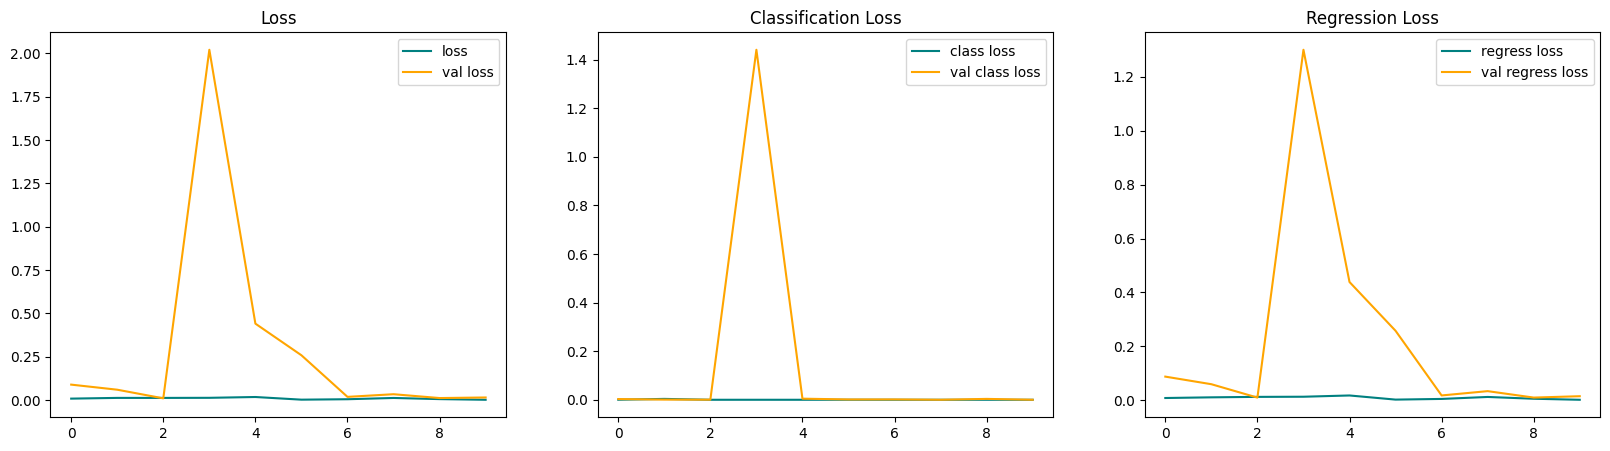

In [122]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 12. Testing On Unseen Data

In [123]:
test_data = test.as_numpy_iterator()

In [124]:
test_sample = test_data.next()

In [131]:
test_sample[0]

array([[[[1.93995103e-01, 2.13112742e-01, 2.63480395e-02],
         [1.77205876e-01, 1.98774517e-01, 6.80147065e-03],
         [1.75490201e-01, 2.03063726e-01, 7.65931373e-03],
         ...,
         [1.57475490e-02, 4.31985296e-02, 0.00000000e+00],
         [6.89338222e-02, 1.00306369e-01, 6.67892164e-03],
         [3.59191179e-01, 3.99387240e-01, 2.80269593e-01]],

        [[1.89460784e-01, 1.97487742e-01, 1.35416668e-02],
         [1.98713228e-01, 2.07046568e-01, 2.37132348e-02],
         [1.92034319e-01, 1.95955887e-01, 2.34068632e-02],
         ...,
         [2.48774514e-02, 5.28186262e-02, 0.00000000e+00],
         [8.40686262e-02, 1.18872546e-01, 1.44607844e-02],
         [3.62990201e-01, 4.03186262e-01, 2.84068614e-01]],

        [[1.86519608e-01, 2.02144608e-01, 1.94852948e-02],
         [1.90441176e-01, 2.13970587e-01, 3.45588252e-02],
         [1.89154416e-01, 2.00919122e-01, 3.22916657e-02],
         ...,
         [2.48161759e-02, 5.61887249e-02, 0.00000000e+00],
         [

In [132]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


## 12.1 Seeing Predicted Results

In [139]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    sample_image = sample_image.copy()
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 13. Exporting Model

In [137]:
facetracker.save('/content/face_detector.h5')


In [138]:
from google.colab import files
files.download('/content/face_detector.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>